In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from yellowbrick.features import FeatureImportances
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score, roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from collections import Counter
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import model_from_json
import json
import joblib 
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv("data/data2.csv")  # CSV dosyasını okuyup bir pandas DataFrame'e aktarıyoruz
copied_data = dataset.copy()  # Orijinal veri setini değiştirmemek için bir yedek kopya alıyoruz
copied_data.info()  # Veri çerçevesinin genel durum bilgilerini kontrol ediyoruz


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     4024 non-null   int64  
 1   Race                    4024 non-null   object 
 2   Marital Status          4024 non-null   object 
 3   Unnamed: 3              0 non-null      float64
 4   T Stage                 4024 non-null   object 
 5   N Stage                 4024 non-null   object 
 6   6th Stage               4024 non-null   object 
 7   Grade                   4024 non-null   object 
 8   A Stage                 4024 non-null   object 
 9   Tumor Size              4024 non-null   int64  
 10  Estrogen Status         4024 non-null   object 
 11  Progesterone Status     4024 non-null   object 
 12  Regional Node Examined  4024 non-null   int64  
 13  Reginol Node Positive   4024 non-null   int64  
 14  Survival Months         4024 non-null   

In [3]:
copied_data.drop(["Unnamed: 3"], axis=1, inplace=True)  # Belirtilen sütunu veri çerçevesinden kalıcı olarak kaldırıyoruz

In [4]:
copied_data.shape # Veri çerçevesinin boyutunu görüntülüyoruz

(4024, 15)

In [5]:
copied_data.describe().T # Veri çerçevesindeki tüm sayısal sütunların temel istatistiklerini döndürüyoruz

,count,mean,std,min,25%,50%,75%,max
Age,4024.0,53.972167,8.963134,30.0,47.0,54.0,61.0,69.0
Tumor Size,4024.0,30.473658,21.119696,1.0,16.0,25.0,38.0,140.0
Regional Node Examined,4024.0,14.357107,8.099675,1.0,9.0,14.0,19.0,61.0
Reginol Node Positive,4024.0,4.158052,5.109331,1.0,1.0,2.0,5.0,46.0
Survival Months,4024.0,71.297962,22.921430,1.0,56.0,73.0,90.0,107.0


In [6]:
import pandas as pd

def convert_object_columns_to_factors(data):
    modified_data = data.copy()
    column_mappings = {}

    for col in data.select_dtypes(include=['object']).columns:
        modified_data[col], unique_items = pd.factorize(data[col])
        column_mappings[col] = unique_items.tolist()

    return modified_data, column_mappings

transformed_data, label_mappings = convert_object_columns_to_factors(copied_data)
print("\nEtiket Eşleştirmeleri:")
print(label_mappings)


Etiket Eşleştirmeleri:
{'Race ': ['Other (American Indian/AK Native, Asian/Pacific Islander)', 'White', 'Black'], 'Marital Status': ['Married (including common law)', 'Divorced', 'Single (never married)', 'Widowed', 'Separated'], 'T Stage ': ['T2', 'T1', 'T3', 'T4'], 'N Stage': ['N3', 'N2', 'N1'], '6th Stage': ['IIIC', 'IIIA', 'IIB', 'IIA', 'IIIB'], 'Grade': ['Moderately differentiated; Grade II', 'Poorly differentiated; Grade III', 'Well differentiated; Grade I', 'Undifferentiated; anaplastic; Grade IV'], 'A Stage': ['Regional', 'Distant'], 'Estrogen Status': ['Positive', 'Negative'], 'Progesterone Status': ['Positive', 'Negative'], 'Status': ['Alive', 'Dead']}


In [7]:
copied_data = transformed_data.copy()

In [8]:
# Eksik verilerin toplamını ve yüzdesini hesaplayalım
missing_values = copied_data.isnull().sum()  # Her sütundaki eksik değerlerin sayısı
missing_ratios = (missing_values / len(copied_data)) * 100  # Eksik değerlerin yüzde oranı

# Eksik verilere dair genel bir tablo oluşturalım
missing_overview = pd.DataFrame({
    'Eksik Değer Sayısı': missing_values,
    'Eksik Değer Oranı (%)': missing_ratios
})

missing_overview

,Eksik Değer Sayısı,Eksik Değer Oranı (%)
Age,0,0.0
Race,0,0.0
Marital Status,0,0.0
T Stage,0,0.0
N Stage,0,0.0
6th Stage,0,0.0
Grade,0,0.0
A Stage,0,0.0
Tumor Size,0,0.0
Estrogen Status,0,0.0


In [9]:
# Özellikleri (features) ve hedef değişkeni (target) ayırıyoruz
features = copied_data.drop(columns=["Status"])
target = copied_data["Status"]

# Başlangıç sınıf dağılımını kontrol ediyoruz
print("Başlangıç sınıf dağılımı:", Counter(target))

# RandomUnderSampler kullanarak veri setini dengeliyoruz
undersampler = RandomUnderSampler(random_state=42)
balanced_features, balanced_target = undersampler.fit_resample(features, target)

# Dengeleme sonrası sınıf dağılımını kontrol ediyoruz
print("Under-sampling sonrası sınıf dağılımı:", Counter(balanced_target))

# Dengelenmiş veri setini birleştiriyoruz
balanced_dataset = pd.concat(
    [pd.DataFrame(balanced_features, columns=features.columns), pd.DataFrame(balanced_target, columns=['Status'])],
    axis=1
)

# Sonuç olarak dengelenmiş veri setinin sınıf dağılımını yazdırıyoruz
print("Dengelenmiş veri seti sınıf dağılımı:", Counter(balanced_dataset['Status']))

Başlangıç sınıf dağılımı: Counter({0: 3408, 1: 616})
Under-sampling sonrası sınıf dağılımı: Counter({0: 616, 1: 616})
Dengelenmiş veri seti sınıf dağılımı: Counter({0: 616, 1: 616})


In [10]:
copied_data = balanced_dataset.copy()  # Dengelenmiş veri setini yedekliyoruz


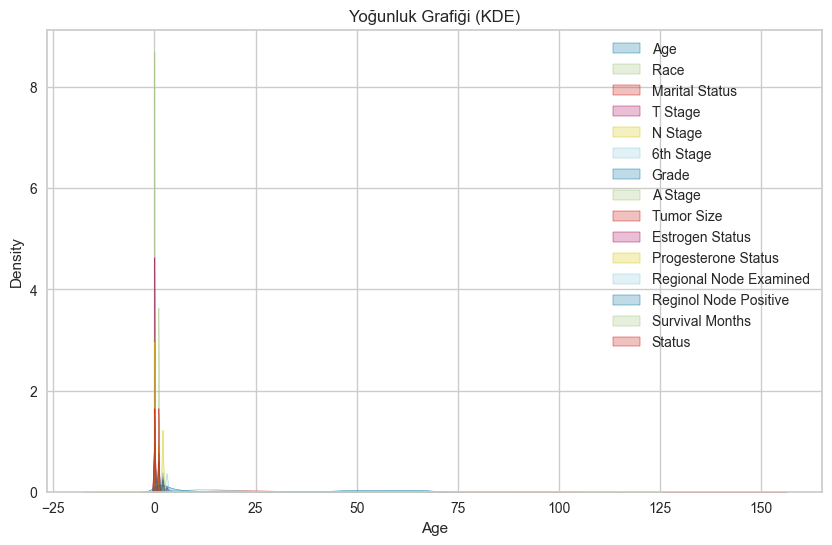

In [11]:
import seaborn as sns

# Sayısal sütunları seçiyoruz
numeric_columns = copied_data.select_dtypes(include=['float64', 'int64']).columns

# Her sütun için yoğunluk grafiği çiziyoruz
plt.figure(figsize=(10, 6))
for col in numeric_columns:
    sns.kdeplot(copied_data[col], shade=True, label=col)

plt.title('Yoğunluk Grafiği (KDE)')
plt.legend()
plt.show()

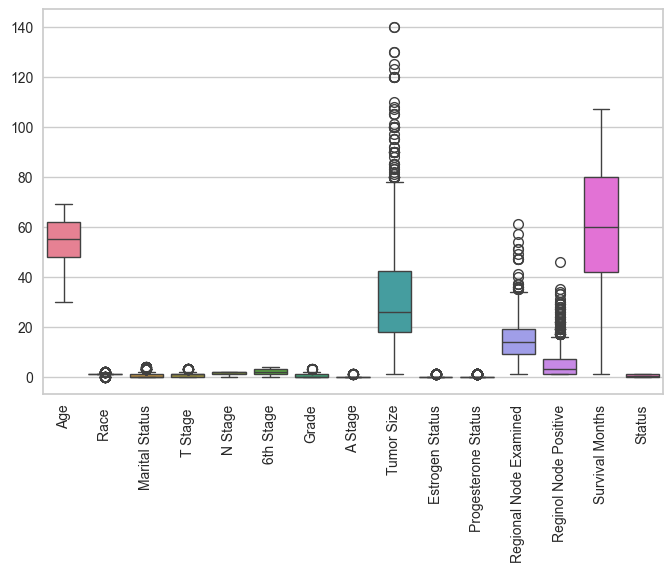

In [12]:
# Kutu grafikleri ile verinin dağılımını görselleştiriyoruz
plt.figure(figsize=(8, 5))
sns.boxplot(data=copied_data[numeric_columns])
plt.xticks(rotation=90)
plt.show()


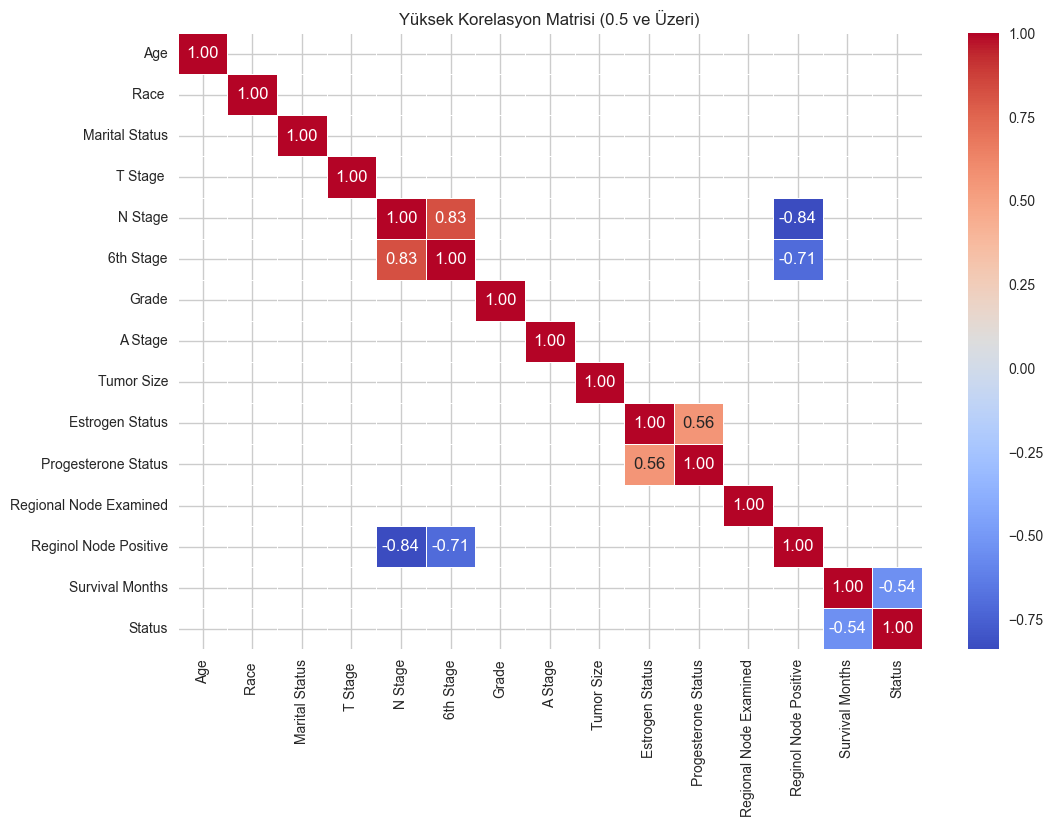

In [13]:
# Korelasyon matrisini hesaplıyoruz
correlation_matrix = copied_data[numeric_columns].corr()

# Sadece yüksek korelasyonları filtreliyoruz (örneğin, > 0.5)
high_corr = correlation_matrix[correlation_matrix.abs() > 0.5]

# Korelasyon matrisini ısı haritası olarak görselleştiriyoruz, farklı bir renk paleti kullanıyoruz
plt.figure(figsize=(12, 8))
sns.heatmap(high_corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Yüksek Korelasyon Matrisi (0.5 ve Üzeri)')
plt.show()


In [14]:
# Bağımlı ve bağımsız değişkenleri ayırıyoruz
features_data = copied_data.drop(columns=['Status'])  # Hedef sütunu (Status) ayırıyoruz
target_data = copied_data['Status']

# Eğitim ve test verilerini ayırıyoruz
X_train, X_test, y_train, y_test = train_test_split(features_data, target_data, test_size=0.2, random_state=42)

# SelectKBest ile özellik seçimi yapıyoruz
feature_selector = SelectKBest(f_classif, k='all')  # Tüm özelliklerin skorlarını alıyoruz
X_selected = feature_selector.fit_transform(X_train, y_train)

# Özelliklerin skorlarını alıyoruz
feature_scores = feature_selector.scores_
feature_names = features_data.columns

# Skorları bir DataFrame'de topluyoruz
feature_scores_df = pd.DataFrame({'Feature': feature_names, 'Score': feature_scores})
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# En yüksek 10 özelliği seçiyoruz
top_10_features = feature_scores_df.head(10)
print(top_10_features)


                  Feature       Score
13        Survival Months  405.631893
4                 N Stage  122.100822
12  Reginol Node Positive  108.863690
5               6th Stage   97.821867
10    Progesterone Status   48.094594
9         Estrogen Status   34.426004
8              Tumor Size   30.500844
7                 A Stage   12.526374
2          Marital Status   11.606861
1                   Race     9.269589


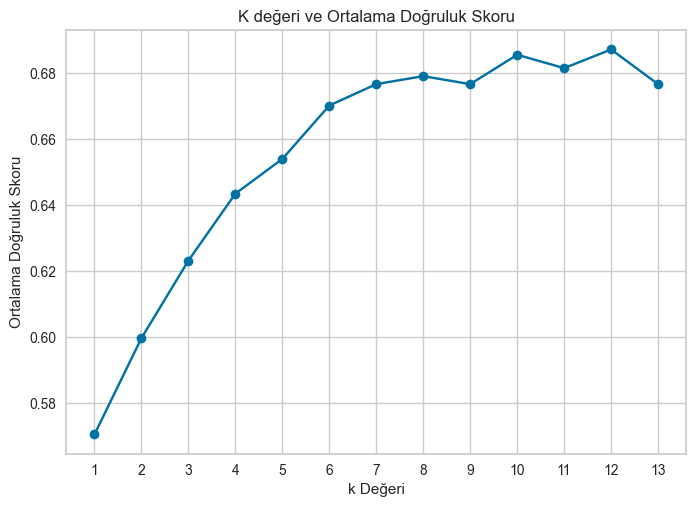

En yüksek doğruluk skoru 0.6872 ile k=12 değerinde elde edildi.


In [15]:
# Özellikler ve hedef değişkeni ayırıyoruz
features_data = copied_data.drop(columns=['Status'])  # Hedef değişkeni çıkarıyoruz (Status)
target_data = copied_data['Status']  # Hedef değişkeni (Status)

# K-NN modelini kuruyoruz ve farklı k değerleriyle performansını değerlendiriyoruz
k_values = range(1, 14)  # k=1'den k=13'e kadar deneyebiliriz
mean_accuracy_scores = []

# Her k değeri için cross-validation sonuçlarını hesaplıyoruz
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    cross_val_results = cross_val_score(knn_model, features_data, target_data, cv=5, scoring='accuracy')  # 5 katlamalı cross-validation
    mean_accuracy_scores.append(np.mean(cross_val_results))

# k ve doğruluk skoru grafikle gösteriliyor
plt.plot(k_values, mean_accuracy_scores, marker='o')
plt.title('K değeri ve Ortalama Doğruluk Skoru')
plt.xlabel('k Değeri')
plt.ylabel('Ortalama Doğruluk Skoru')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# En yüksek doğruluk skoruna sahip k değerini buluyoruz
best_k_value = k_values[np.argmax(mean_accuracy_scores)]
print(f"En yüksek doğruluk skoru {max(mean_accuracy_scores):.4f} ile k={best_k_value} değerinde elde edildi.")


In [16]:
# Belirli sütunları seçiyoruz
copied_data = copied_data[['Age', 'Race ', 'T Stage ', 'N Stage', '6th Stage', 'Grade', 'A Stage',
       'Estrogen Status', 'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status']]


In [17]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score, roc_curve, auc

def train_models(X_train, y_train):
    # Model isimleri ve modelleri saklamak için bir liste oluşturuyoruz
    models = []
    
    # CatBoost Modeli
    cat_boost_model = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
    cat_boost_model.fit(X_train, y_train)
    models.append({"model_name": "CatBoost", "model": cat_boost_model})
    print("CatBoostClassifier modeli eğitildi.")
    
    # LightGBM Modeli
    lgbm_model = LGBMClassifier(n_estimators=100, random_state=42)
    lgbm_model.fit(X_train, y_train)
    models.append({"model_name": "LightGBM", "model": lgbm_model})
    print("LGBMClassifier modeli eğitildi.")
    
    # Random Forest Modeli
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    models.append({"model_name": "RandomForest", "model": rf_model})
    print("RandomForestClassifier modeli eğitildi.")
    
    # Extra Trees Modeli
    extra_trees_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
    extra_trees_model.fit(X_train, y_train)
    models.append({"model_name": "ExtraTrees", "model": extra_trees_model})
    print("ExtraTreesClassifier modeli eğitildi.")
    
    # Bagging Classifier Modeli
    bagging_model = BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),  # base_estimator yerine estimator
        n_estimators=100,
        random_state=42
    )
    bagging_model.fit(X_train, y_train)
    models.append({"model_name": "Bagging", "model": bagging_model})
    print("BaggingClassifier modeli eğitildi.")
    
    return models

# Eğitim ve test setlerine ayıralım
X_train, X_test, y_train, y_test = train_test_split(features_data, target_data, test_size=0.3, random_state=42)

# Modelleri eğitiyoruz
trained_models = train_models(X_train, y_train)

# Eğitilen modellerin isimlerini ve türlerini yazdıralım
for model_info in trained_models:
    print(f"{model_info['model_name']} modeli eğitildi ve saklandı.")

# Model değerlendirme fonksiyonu
def evaluate_model(model, X_test, y_test):
    # Tahminler
    y_pred = model.predict(X_test)
    
    # Metrikler
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # ROC ve AUC
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc_score = auc(fpr, tpr)
    
    # Sonuçları döndür
    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "precision": precision,
        "sensitivity": sensitivity,
        "kappa": kappa,
        "fpr": fpr,
        "tpr": tpr,
        "auc": auc_score
    }

# Modelleri değerlendirme
evaluation_results = {}
for model_info in trained_models:
    model_name = model_info['model_name']
    model = model_info['model']
    print(f"Evaluating {model_name}...")
    evaluation_results[model_name] = evaluate_model(model, X_test, y_test)

# Değerlendirme sonuçlarını yazdıralım
for model_name, result in evaluation_results.items():
    print(f"\n{model_name} Değerlendirme Sonuçları:")
    for metric, value in result.items():
        print(f"{metric}: {value}")


CatBoostClassifier modeli eğitildi.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 439, number of negative: 423
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 862, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509281 -> initscore=0.037127
[LightGBM] [Info] Start training from score 0.037127
LGBMClassifier modeli eğitildi.
RandomForestClassifier modeli eğitildi.
ExtraTreesClassifier modeli eğitildi.
BaggingClassifier modeli eğitildi.
CatBoost modeli eğitildi ve saklandı.
LightGBM modeli eğitildi ve saklandı.
RandomForest modeli eğitildi ve saklandı.
ExtraTrees modeli eğitildi ve saklandı.
Bagging modeli eğitildi ve sakla

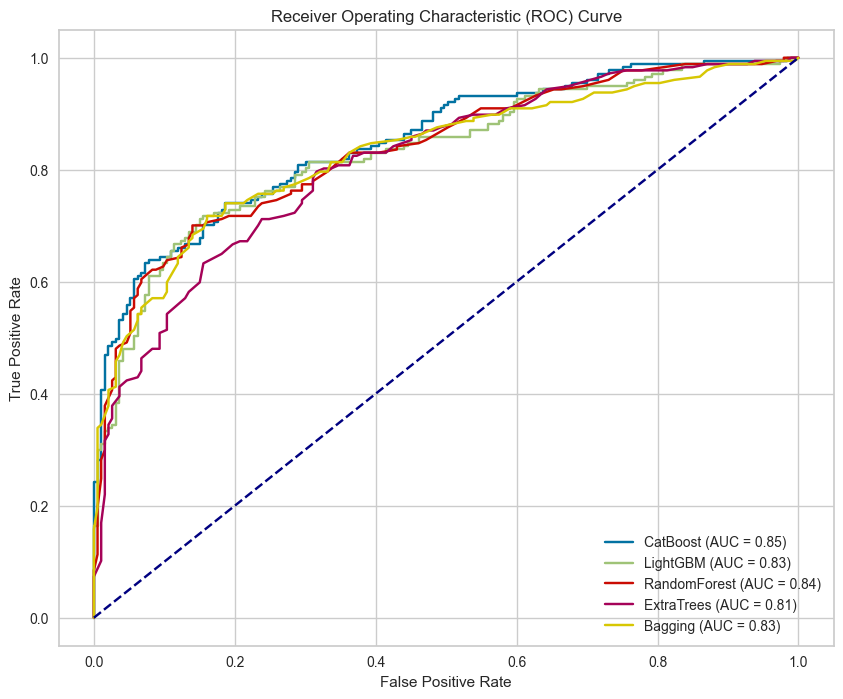

In [18]:
import matplotlib.pyplot as plt

# ROC Eğrisini çizmek için figure boyutunu ayarlıyoruz
plt.figure(figsize=(10, 8))

# Tüm modellerin ROC eğrisini çizelim
for model_name, result in evaluation_results.items():
    plt.plot(result['fpr'], result['tpr'], label=f"{model_name} (AUC = {result['auc']:.2f})")

# Diagonal çizgi (rastgele tahmin)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Grafik başlığı ve etiketler
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Legend ekliyoruz
plt.legend(loc="lower right")

# Grafiği gösteriyoruz
plt.show()


In [19]:
# Model Performans Sonuçlarını Yazdırma
results_df = pd.DataFrame(evaluation_results).T  # 'results' sözlüğünü DataFrame'e dönüştürme
results_df[['accuracy', 'f1_score', 'precision', 'sensitivity', 'kappa']]  # İlgili metrikleri gösterme

,accuracy,f1_score,precision,sensitivity,kappa
CatBoost,0.767568,0.742515,0.789809,0.700565,0.532073
LightGBM,0.764865,0.74928,0.764706,0.734463,0.528075
RandomForest,0.764865,0.744868,0.77439,0.717514,0.52741
ExtraTrees,0.724324,0.721311,0.698413,0.745763,0.449164
Bagging,0.778378,0.761628,0.784431,0.740113,0.554884


In [20]:
# Accuracy'ye göre sıralama
sorted_results = results_df.sort_values(by='accuracy', ascending=False)

# En üstteki modeli yazdır
top_model = sorted_results.iloc[0]  # En yüksek doğruluk skoruna sahip modeli alıyoruz
print("En iyi model (Accuracy'ye göre):")
print(top_model)


En iyi model (Accuracy'ye göre):
accuracy                                                0.778378
f1_score                                                0.761628
precision                                               0.784431
sensitivity                                             0.740113
kappa                                                   0.554884
fpr            [0.0, 0.0, 0.0, 0.0051813471502590676, 0.00518...
tpr            [0.0, 0.10734463276836158, 0.15819209039548024...
auc                                                     0.831094
Name: Bagging, dtype: object


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, cohen_kappa_score

# Veriyi hazırlama
X_train, X_test, y_train, y_test = train_test_split(features_data, target_data, test_size=0.3, random_state=42)

# Yapay Sinir Ağı Modeli
ann_model = Sequential([
    Dense(256, activation='tanh', input_dim=X_train.shape[1]),  # İlk katman
    Dropout(0.2),  # Dropout oranı arttırıldı
    Dense(128, activation='tanh'),  # İkinci katman
    Dropout(0.2),  # Dropout oranı arttırıldı
    Dense(64, activation='relu'),  # Üçüncü katman
    Dense(1, activation='sigmoid')  # Çıktı katmanı, binary classification
])

ann_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modeli eğitme
ann_history = ann_model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Modeli değerlendirme
ann_metrics = ann_model.evaluate(X_test, y_test)

# Sonuçları kaydetme
ann_metrics_dict = {
    'accuracy': ann_metrics[1],
    'f1_score': f1_score(y_test, ann_model.predict(X_test).round()),
    'precision': precision_score(y_test, ann_model.predict(X_test).round()),
    'sensitivity': recall_score(y_test, ann_model.predict(X_test).round()),
    'kappa': cohen_kappa_score(y_test, ann_model.predict(X_test).round())
}

print(ann_metrics_dict)


Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6601 - loss: 0.6309 - val_accuracy: 0.7649 - val_loss: 0.5414
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7614 - loss: 0.5123 - val_accuracy: 0.7486 - val_loss: 0.5396
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7369 - loss: 0.5374 - val_accuracy: 0.7378 - val_loss: 0.5480
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7543 - loss: 0.5099 - val_accuracy: 0.7541 - val_loss: 0.5286
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7700 - loss: 0.4722 - val_accuracy: 0.7027 - val_loss: 0.6133
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7579 - loss: 0.4884 - val_accuracy: 0.7514 - val_loss: 0.5194
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7525 - loss: 0.4885 - val_accuracy: 0.7757 - val_loss: 0.5420
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7489 - loss: 0.5230 - val_accuracy: 0.7595 - 

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np

# Veriyi hazırlama
X = copied_data.drop(columns=['Status'], axis=1).values
y = copied_data['Status'].values
# Veriyi 2D formatına dönüştürme
X = X.reshape(X.shape[0], 12, 1)  # (örnek sayısı, özellik sayısı, kanal sayısı)

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cnn_model = Sequential([
    Conv2D(128, (2, 2), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1), padding='same'),
    MaxPooling2D(pool_size=(1, 2), padding='same'),  # Boyutları çok küçültmüyor
    Conv2D(64, (2, 2), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(1, 2), padding='same'),  # Boyutları çok küçültmüyor
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli eğitme
cnn_history = cnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Modeli değerlendirme
cnn_metrics = cnn_model.evaluate(X_test, y_test)

# Sonuçları kaydetme
cnn_metrics_dict = {
    'accuracy': cnn_metrics[1],
    'f1_score': f1_score(y_test, cnn_model.predict(X_test).round()),
    'precision': precision_score(y_test, cnn_model.predict(X_test).round()),
    'sensitivity': recall_score(y_test, cnn_model.predict(X_test).round()),
    'kappa': cohen_kappa_score(y_test, cnn_model.predict(X_test).round())
}
cnn_metrics_dict


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6331 - loss: 0.6330 - val_accuracy: 0.6316 - val_loss: 0.6258
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7282 - loss: 0.5459 - val_accuracy: 0.7004 - val_loss: 0.5782
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7414 - loss: 0.5203 - val_accuracy: 0.7773 - val_loss: 0.5284
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7883 - loss: 0.4789 - val_accuracy: 0.7692 - val_loss: 0.5110
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7658 - loss: 0.4979 - val_accuracy: 0.7490 - val_loss: 0.5225
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7579 - loss: 0.5007 - val_accuracy: 0.7490 - val_loss: 0.5128
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7556 - loss: 0.5005 - val_accuracy: 0.7490 - val_loss: 0.5120
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7639 - loss: 0.4807 - val_accuracy: 0.7652 - v

{'accuracy': 0.7651821970939636,
 'f1_score': 0.7264150943396226,
 'precision': 0.8191489361702128,
 'sensitivity': 0.652542372881356,
 'kappa': 0.5253147779986747}

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

# Veriyi eğitim ve test setlerine ayırma
X = copied_data.drop(columns=['Status']).values
y = copied_data['Status'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli oluşturuyoruz
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli eğitme
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Modeli değerlendirme
y_pred = (model.predict(X_test) > 0.5)

# Performans metriklerini hesaplama
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)

# Metrikleri bir dictionary olarak kaydediyoruz
model_metrics = {
    'accuracy': accuracy,
    'f1_score': f1,
    'precision': precision,
    'sensitivity': sensitivity,
    'kappa': cohen_kappa_score(y_test, y_pred.round())
}
model_metrics

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5573 - loss: 0.8958 - val_accuracy: 0.7247 - val_loss: 0.5830
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6664 - loss: 0.6218 - val_accuracy: 0.7409 - val_loss: 0.5788
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6726 - loss: 0.5942 - val_accuracy: 0.7571 - val_loss: 0.5681
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6741 - loss: 0.5822 - val_accuracy: 0.7449 - val_loss: 0.5298
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7212 - loss: 0.5508 - val_accuracy: 0.7409 - val_loss: 0.5608
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7496 - loss: 0.5338 - val_accuracy: 0.7409 - val_loss: 0.5352
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7469 - loss: 0.5160 - val_accuracy: 0.7449 - val_loss: 0.5618
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7320 - loss: 0.5635 - val_accuracy: 0.7490 - v

{'accuracy': 0.7449392712550608,
 'f1_score': 0.6735751295336787,
 'precision': 0.8666666666666667,
 'sensitivity': 0.5508474576271186,
 'kappa': 0.48079810483467356}

In [24]:
new_data = {
    "ANN": ann_metrics_dict,
    "CNN": cnn_metrics_dict,
    "DNN": model_metrics
}

# Yeni verileri ekleme
for model, metrics in new_data.items():
    results_df.loc[model] = metrics

results_df = results_df[['accuracy', 'f1_score', 'precision', 'sensitivity', 'kappa']]
results_df

,accuracy,f1_score,precision,sensitivity,kappa
CatBoost,0.767568,0.742515,0.789809,0.700565,0.532073
LightGBM,0.764865,0.74928,0.764706,0.734463,0.528075
RandomForest,0.764865,0.744868,0.77439,0.717514,0.52741
ExtraTrees,0.724324,0.721311,0.698413,0.745763,0.449164
Bagging,0.778378,0.761628,0.784431,0.740113,0.554884
ANN,0.762162,0.731707,0.794702,0.677966,0.520514
CNN,0.765182,0.726415,0.819149,0.652542,0.525315
DNN,0.744939,0.673575,0.866667,0.550847,0.480798


In [25]:
# accuracy sütununa göre azalan sırayla sıralama
results_df_sorted = results_df.sort_values(by='accuracy', ascending=False)

# En iyi accuracy'ye sahip modelin ismi ve metriklerini alalım
best_model = results_df_sorted.index[0]  # İlk sıradaki model en iyi accuracy'ye sahip
best_model_metrics = results_df_sorted.iloc[0]  # En iyi accuracy'ye sahip modelin tüm metriklerini alıyoruz

# En iyi accuracy'ye sahip modelin detaylarını yazdırma
print(f"En iyi accuracy'ye sahip model: {best_model}")
print(best_model_metrics)


En iyi accuracy'ye sahip model: Bagging
accuracy       0.778378
f1_score       0.761628
precision      0.784431
sensitivity    0.740113
kappa          0.554884
Name: Bagging, dtype: object


In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Parametre grid'i tanımlama
param_grid = {
    'n_estimators': [10, 50, 100],  # Toplam zayıf öğrenicilerin (ağaçların) sayısı
    'max_samples': [0.5, 0.7, 1.0],  # Her zayıf öğrenici için örnekleme oranı
    'max_features': [0.5, 0.7, 1.0],  # Her zayıf öğrenici için özellik oranı
    'bootstrap': [True, False],  # Örnekleme yöntemi (bootstrap veya değil)
    'bootstrap_features': [True, False],  # Özellik seçimi için bootstrap
    'estimator__max_depth': [3, 5, None],  # Temel öğrenici (DecisionTreeClassifier) için maksimum derinlik
    'estimator__min_samples_split': [2, 5, 10],  # Dallanma için minimum örnek sayısı
}

# BaggingClassifier modeli
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)

# GridSearchCV nesnesini oluşturma
grid_search_bagging = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid,
    cv=5,  # 5 katlı çapraz doğrulama
    scoring='accuracy',
    n_jobs=-1,  # Paralel işlem sayısı (-1 tüm çekirdekleri kullanır)
    verbose=1
)

# Modeli eğitim verisiyle eğitme
grid_search_bagging.fit(X_train, y_train)

# En iyi parametreleri ve skorları yazdırma
print("Bagging En iyi parametreler:", grid_search_bagging.best_params_)
print("Bagging En iyi doğruluk skoru:", grid_search_bagging.best_score_)

# En iyi modeli alma
best_bagging_model = grid_search_bagging.best_estimator_


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Bagging En iyi parametreler: {'bootstrap': True, 'bootstrap_features': True, 'estimator__max_depth': 5, 'estimator__min_samples_split': 10, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10}
Bagging En iyi doğruluk skoru: 0.7939086294416244


In [30]:
import joblib
import numpy as np
from sklearn.model_selection import GridSearchCV

def make_predictions_with_gridsearchcv(grid_search, new_samples):
    # GridSearchCV ile elde edilen en iyi model
    best_model = grid_search.best_estimator_

    # Tahmin yap
    predictions = best_model.predict(new_samples)
    
    # Tahmin sonuçlarını döndür
    result = []
    for i, prediction in enumerate(predictions):
        result.append(f"Örnek {i+1}: {'Pozitif' if prediction == 1 else 'Negatif'}")
    
    return result

# Yeni örnekler (Veri setinizde bulunan özniteliklere benzer örnekler)
# Bu örneklerin her birinin, eğitim verisinde kullanılan özelliklerle aynı uzunlukta ve formatta olması gerektiğini unutmayın.
new_samples = np.array([
    [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1],  # Örneğin: viral_hepatit, diyabet, erkek vb.
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1],  # Örneğin: kronik_bobrek_hastaligi, safra_kesesi vb.
])

# Tahmin yap
predictions = make_predictions_with_gridsearchcv(grid_search_bagging, new_samples)

# Sonuçları yazdır
for result in predictions:
    print(result)


Örnek 1: Pozitif
Örnek 2: Pozitif
